# Creating Customer Segments

## Edderic Ugaddan

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [22]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Exploratory Data Analysis
### It seems that Fresh and Grocery products have the biggest variances.
### There also seems to be two clusters...

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112cae690>]], dtype=object)

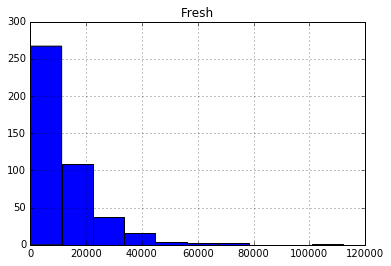

In [23]:
data[['Fresh']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111f7ac50>]], dtype=object)

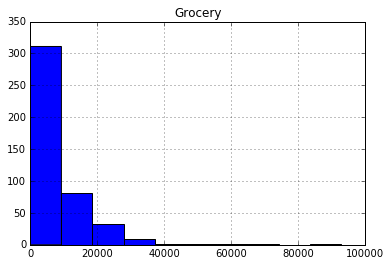

In [24]:
data[['Grocery']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11208f150>]], dtype=object)

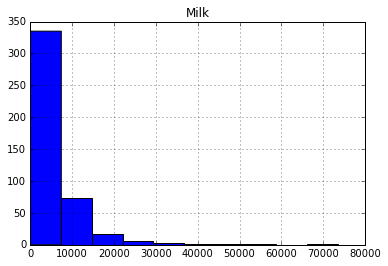

In [25]:
data[['Milk']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11317f7d0>]], dtype=object)

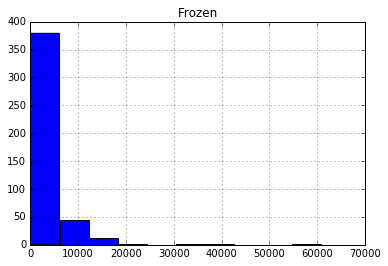

In [26]:
data[['Frozen']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113460310>]], dtype=object)

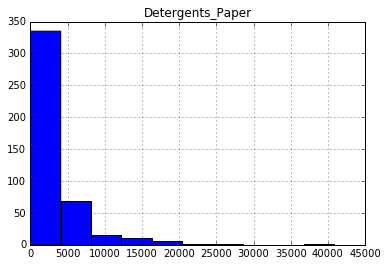

In [27]:
data[['Detergents_Paper']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11349bd50>]], dtype=object)

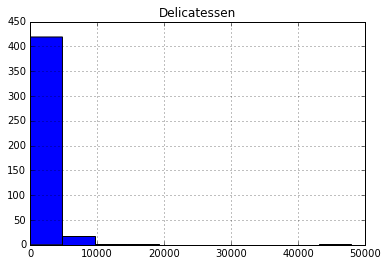

In [28]:
data[['Delicatessen']].hist()

##Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer: 

Right now, I have a dataset of 440 rows and 6 columns (Fresh, Milk, Grocery, etc.) When I perform PCA, I expect the dataset to be transformed into another 440x6 matrix, where each customer's wholesale delivery is no longer represented explicitly in terms of the original columns (Fresh, Milk, Grocery, etc.) but as Principal Components (i.e. components that explain the variances in the data the best). Judging by the variances in the histograms of the products, I expect the first two principal components to correspond well to "Fresh" and "Grocery" products. In the histograms above, there seems to be a trend where order numbers for each category start really high, and then exponentially drop down to having no orders, and then followed again by some orders. This "gulf" suggests two clusters -- one for "small" businesses and another for "large" businesses.

On the other hand, with ICA, I guess we will get six statistically independent components (i.e. knowing about one component does not tell us anything about the other component). ICA is typically used for Blind Source Separation, where we are trying to extract independent signals from their mixtures. I suppose we might be able to represent spending patterns of "big" and "small" companies via a linear combination of these statistically independent signals. For example, we might get a notion of how "predictable" one signal is, given that we have knowledge about the other signals; if a transformed ICA component strongly corresponds with annual spending on "Fresh" products, then the latter could be most likely represented with just the transformed independent component times some coefficient. On the other hand, let's say that annual spending on "Milk" products doesn't seem to correspond as strongly with a single transformed ICA component. This would suggest that spending on "Milk" products is probably somewhat more "predictable" given knowledge of other signals, and may be represented by a linear combination of several independent components, not just one independent component.)

###PCA

In [124]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print pca.explained_variance_ratio_

[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]]
[ 0.45961362  0.40517227]


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: 

Variance drops off relatively slowly from the 1st principal component to the 2nd (~5%). However, variance drops significantly from the 2nd principal component to the 3rd. I would just use the first two principal components since they account for 0.45961362 + 0.40517227 = 0.86478589, which is quite a significant amount of the variation. I would choose 2 principal components because of the clear "gap" between clusters, as seen in the histograms above.

**3)** What do the dimensions seem to represent? How can you use this information?

Answer: 

The first two dimensions seem to correspond strongly with annual customer spending on "fresh" and "grocery" items. By comparing the original graphs to the graphs of PCA for the first and last 20 customers, it seems that the first principal component is negatively correlated with annual customer spending on freshness (see below). We observe that peaks in "fresh" annual spending per customer correspond to troughs in terms of the first principal component, and similarly, the troughs in "fresh" annual spending per correspond to peaks in the latter. On the other hand, the second principal component seems to follow the general trend of annual spending on "grocery" items.  

This information makes sense. When we look at README, we find out that annual spending on fresh items has the biggest standard deviation (12,647.239) and that annual spending per customer on grocery items has the second biggest standard deviation (9,503.163). PCA finds vectors to project onto so that variances of the data on them are maximized. Standard deviation is just the square root of the variance, so it follows that annual spending on "fresh" and "grocery" products are intimately related to the first and second principal components.

What this tells me is that if I really want the business to pay attention to only a couple of types of products, I would recommend them to focus on products that belong to the "fresh" and "grocery" labels. Together, they seem to capture much of the information about the whole dataset.

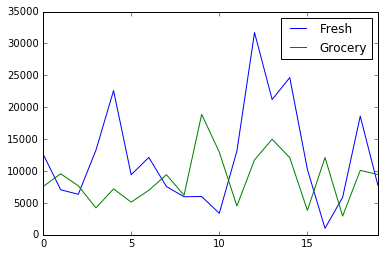

In [3]:
data[['Fresh', 'Grocery']].head(20).plot()

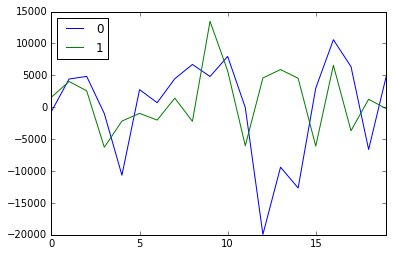

In [4]:
pd.DataFrame(pca.transform(data)).head(20).plot()

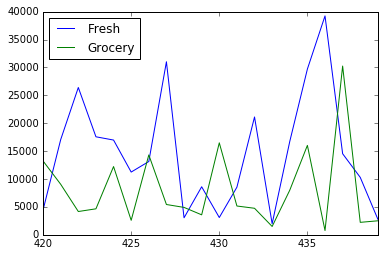

In [5]:
data[['Fresh', 'Grocery']].tail(20).plot()

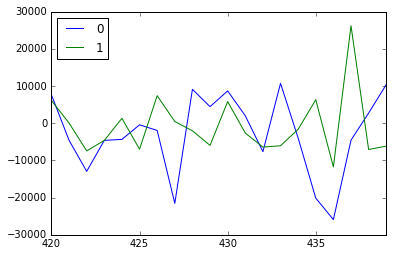

In [6]:
pd.DataFrame(pca.transform(data)).tail(20).plot()

###ICA

In [7]:
means = pd.DataFrame({'Fresh': [12000.30], 
                      'Milk': [5796.27], 
                      'Grocery': [7951.28], 
                      'Frozen': [3071.93], 
                      'Detergents_Paper': [2881.49], 
                      'Delicatessen': [1524.87]})

means

,Delicatessen,Detergents_Paper,Fresh,Frozen,Grocery,Milk
0,1524.87,2881.49,12000.3,3071.93,7951.28,5796.27


In [8]:
columns = ['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicatessen']
columns

['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']

In [9]:
centered = pd.DataFrame(data[columns].values - means[columns].values,columns = columns)
centered

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,668.7,3859.73,-390.28,-2857.93,-207.49,-186.87
1,-4943.3,4013.73,1616.72,-1309.93,411.51,251.13
2,-5647.3,3011.73,-267.28,-666.93,634.51,6319.13
3,1264.7,-4600.27,-3730.28,3332.07,-2374.49,263.13
4,10614.7,-386.27,-753.28,843.07,-1104.49,3660.13
5,-2587.3,2462.73,-2825.28,-2405.93,-1086.49,-73.87
6,125.7,-2597.27,-976.28,-2591.93,258.51,-979.87
7,-4421.3,-840.27,1474.72,-1402.93,439.51,1041.13
8,-6037.3,-2148.27,-1759.28,-2646.93,-1165.49,-774.87
9,-5994.3,5296.73,10929.72,-1912.93,4543.51,573.13


In [10]:
data.head(6)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
5,9413,8259,5126,666,1795,1451


In [233]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA

ica = FastICA()


ica_transformed = ica.fit_transform(centered)

# Transform with ICA and then save to disk so that component ordering does not change.
# from sklearn.externals import joblib
#joblib.dump(ica_transformed, 'ica_transformed.pkl') 
#joblib.dump(ica, 'ica.pkl') 

# Load saved ICA so that PDF report is synchronized with this particular run of ICA
#ica = joblib.load('ica.pkl')
#ica_transformed = joblib.load('ica_transformed.pkl') 

# Print the independent components
print ica.components_

[[ -8.64241920e-07  -1.43742412e-07   7.68374411e-07   1.11469678e-05
   -5.39127869e-07  -5.94888659e-06]
 [ -3.97776051e-06   8.66710498e-07   7.24815279e-07   6.70227023e-07
   -2.26713301e-06   9.96288883e-07]
 [  2.06598417e-07  -1.73800639e-06   6.88039874e-06   3.48347791e-07
   -1.93499978e-06  -1.73869081e-06]
 [ -1.49588353e-07  -9.86001153e-06   5.82416921e-06   3.65946283e-07
   -3.27102258e-06   6.06753122e-06]
 [  3.87713825e-07   2.15115194e-07   5.89475963e-07   5.22109550e-07
   -4.92402372e-07  -1.80849218e-05]
 [  2.80575423e-07  -2.35741513e-06  -1.17944381e-05   1.47575210e-06
    2.81417575e-05   5.67713876e-06]]


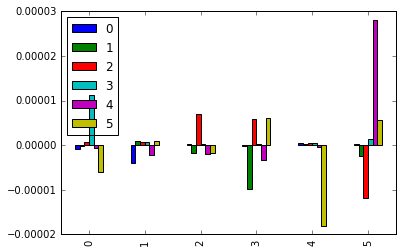

In [316]:
pd.DataFrame(ica.components_).plot(kind='bar')

In [236]:
pd.DataFrame(ica_transformed)

,0,1,2,3,4,5
0,-0.032066,-0.001229,-0.009524,-0.041931,0.002849,-0.015426
1,-0.011380,0.022753,0.001437,-0.029722,-0.005528,-0.018844
2,-0.041126,0.029290,-0.020687,0.005614,-0.116641,0.047214
3,0.033559,-0.003843,-0.012111,0.034027,-0.004548,-0.005215
4,-0.021478,-0.036388,-0.006251,0.023963,-0.061621,0.003714
5,-0.026082,0.011155,-0.022861,-0.038125,-0.001524,-0.007755
6,-0.023688,-0.006758,-0.001877,0.012165,0.015155,0.015560
7,-0.016994,0.017028,0.007544,0.021901,-0.020803,-0.000444
8,-0.020093,0.020974,-0.006938,0.009981,0.009365,-0.016984
9,-0.014365,0.025345,0.054302,0.000243,-0.008343,-0.014785


## Independent Component 1 corresponds to "Fresh" Products

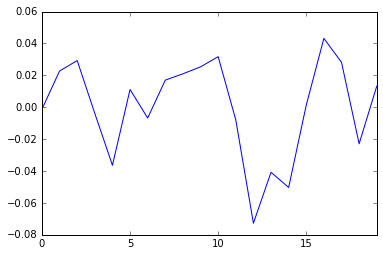

In [271]:
pd.DataFrame(ica_transformed)[1].head(20).plot()

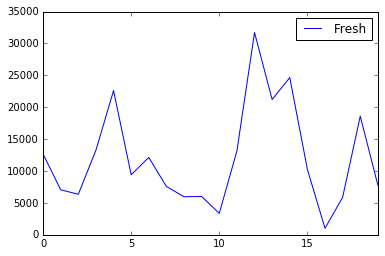

In [238]:
pd.DataFrame(data[['Fresh']].head(20)).plot()

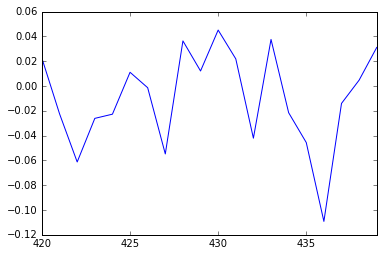

In [272]:
pd.DataFrame(ica_transformed)[1].tail(20).plot()

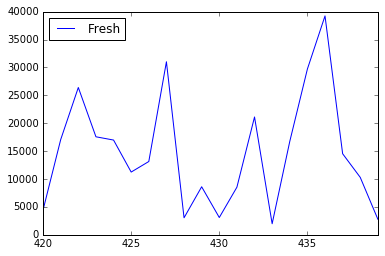

In [240]:
pd.DataFrame(data[['Fresh']].tail(20)).plot()

## Independent Component 2 seems to be quite related negatively correlated with "Grocery" and "Detergent/Paper" products

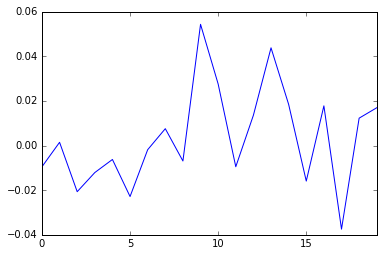

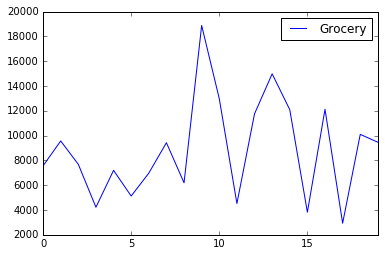

In [279]:
pd.DataFrame(ica_transformed)[2].head(20).plot()
pd.DataFrame(data[['Grocery']].head(20)).plot()

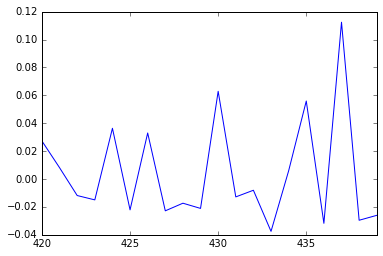

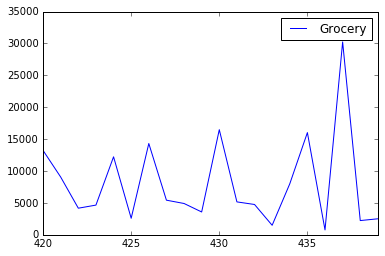

In [281]:
pd.DataFrame(ica_transformed)[2].tail(20).plot()
pd.DataFrame(data[['Grocery']].tail(20)).plot()

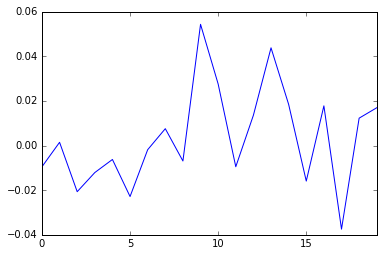

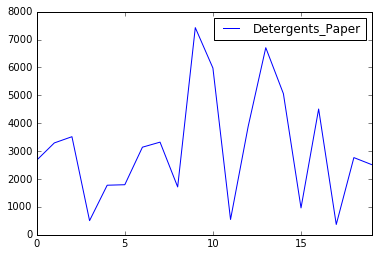

In [290]:
pd.DataFrame(ica_transformed)[2].head(20).plot()
pd.DataFrame(data[['Detergents_Paper']].head(20)).plot()

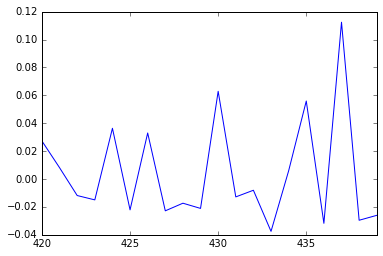

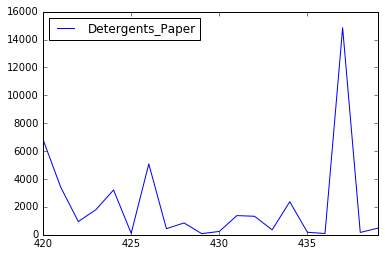

In [291]:
pd.DataFrame(ica_transformed)[2].tail(20).plot()
pd.DataFrame(data[['Detergents_Paper']].tail(20)).plot()

## Independent Component 4 follows the general trend of "Delicatessen" products.

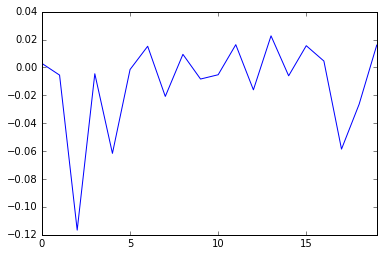

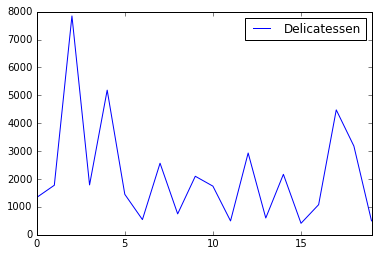

In [317]:
pd.DataFrame(ica_transformed)[4].head(20).plot()
pd.DataFrame(data[['Delicatessen']].head(20)).plot()

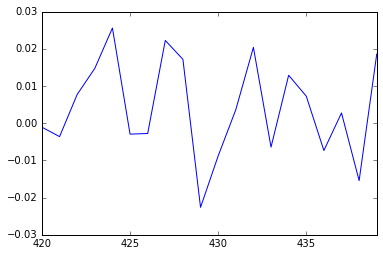

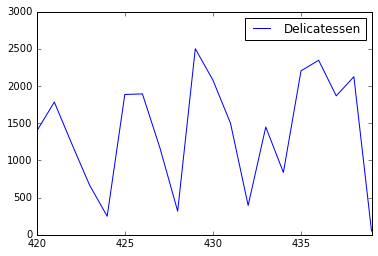

In [296]:
pd.DataFrame(ica_transformed)[4].tail(20).plot()
pd.DataFrame(data[['Delicatessen']].tail(20)).plot()

## Independent Component 0 seems to correspond to "Frozen" and somewhat to "Milk" products

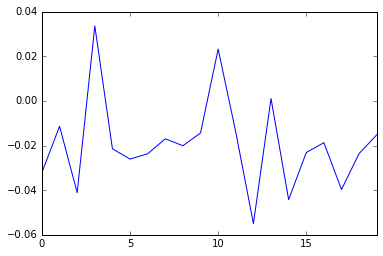

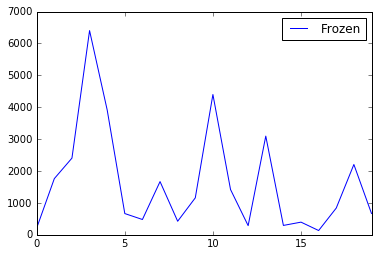

In [310]:
pd.DataFrame(ica_transformed)[0].head(20).plot()
pd.DataFrame(data[['Frozen']].head(20)).plot()

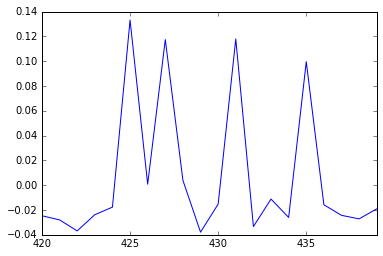

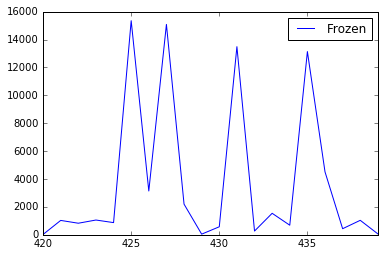

In [311]:
pd.DataFrame(ica_transformed)[0].tail(20).plot()
pd.DataFrame(data[['Frozen']].tail(20)).plot()

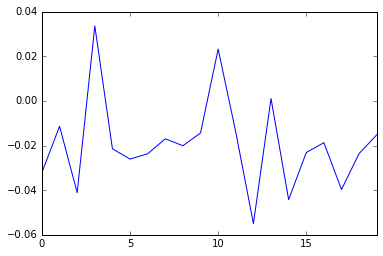

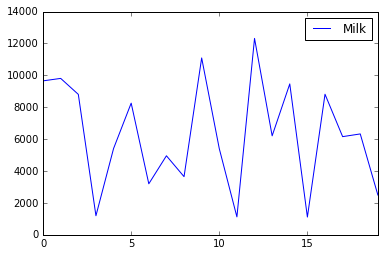

In [313]:
pd.DataFrame(ica_transformed)[0].head(20).plot()
pd.DataFrame(data[['Milk']].head(20)).plot()

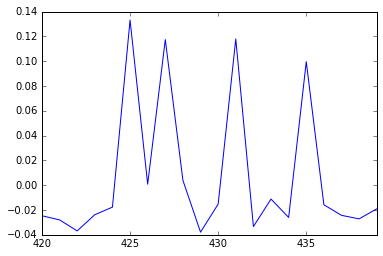

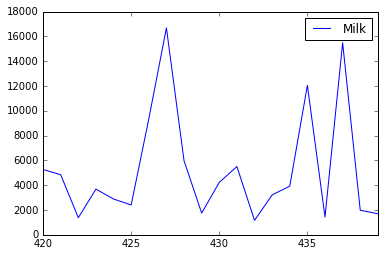

In [314]:
pd.DataFrame(ica_transformed)[0].tail(20).plot()
pd.DataFrame(data[['Milk']].tail(20)).plot()

**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: 

Each vector in the ICA decomposition is an independent component. ICA maps the data for each customer into new a new basis, where data in the new vectors are statistically independent from one another. ICA is usually used for separating superimposed signals (see http://scikit-learn.org/stable/modules/decomposition.html#ica).


It is interesting to note that one component seems to correspond with "fresh" products. A second component seems to correspond with "grocery" and "detergents/paper" products (i.e. dry products). A third component seems to be related to "frozen" and "milk" products (i.e. refrigerated). The last represents "deli" orders. Overall, these vectors make me think of grocery stores, since most of the grocery stores that I've been have these four sections.

##Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

###Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: 

The advantage of K Means Clustering is that it is relatively simple to understand. Once we select a number of clusters (k), the centroids are randomly placed on the feature space and are then iteratively "pulled by rubber bands" toward clumps of points. After several iterations, the centroids have hopefully stabilized on global minima (sometimes they don't), and points in the feature space are assigned to the centroid that is closest to them. Another is that K Means is significantly faster than GMM (see benchmarks below). For 2 clusters, on average, K Means (0.2775208 sec) ran about 27% faster than GMM (0.376286 sec).

The advantage of Gaussian Mixture Models is that their goals are similar to K Means, but they also take into account covariance structure in the data (see http://scikit-learn.org/stable/modules/mixture.html). Another advantage of Gaussian Mixture Models is that they do soft assignment (i.e. assign a probability to the class of the point of interest) instead classifying the point of interest as to belonging to only one class.  This is nice because it reflects the uncertainty in classifying points that are right in between the decision boundaries, unlike K Means.

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [251]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [252]:
import math

In [253]:
log_data = data.applymap(lambda x: math.log(x,2))
log_data

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,13.629015,13.237210,12.884361,7.741467,11.384784,10.385862
1,12.784839,13.260037,13.224002,10.782998,11.685187,10.794416
2,12.633222,13.104599,12.907642,11.231821,11.779719,12.937374
3,13.695337,10.224002,12.043369,12.644758,8.985842,10.804131
4,14.464992,12.401413,12.813380,11.934797,10.795228,12.340128
5,13.200439,13.011751,12.323618,9.379378,10.809768,10.502832
6,13.565816,11.643405,12.767978,8.906891,11.616549,9.090112
7,12.887792,12.274960,13.202430,10.704768,11.697402,11.325305
8,12.541823,11.832890,12.596190,8.731319,10.744834,9.550747
9,12.552189,13.437362,14.204648,10.178665,12.858175,11.034799


In [254]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
reduced_data = pca.transform(log_data)
print reduced_data[:10]  # print upto 10 elements

[[ 13444.53792159  -8804.4225931 ]
 [ 13444.84949531  -8803.98162552]
 [ 13444.82219707  -8804.13846858]
 [ 13444.09756691  -8807.57156392]
 [ 13443.05104379  -8805.18280252]
 [ 13444.75669019  -8805.15430001]
 [ 13444.71225598  -8805.33778374]
 [ 13444.84551114  -8804.48138185]
 [ 13445.689063    -8805.54703103]
 [ 13445.07883115  -8802.66103033]]


In [255]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'

def cluster(clusterer):
    clusterer.fit(reduced_data)
    clusters = clusterer
    print clusters
    return clusters

In [256]:
# Plot the decision boundary by building a mesh grid to populate a graph.

def plot_boundary(clusters):
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    hx = (x_max-x_min)/1000.
    hy = (y_max-y_min)/1000.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])
    return Z,xx,yy,x_min,x_max,y_min,y_max

In [257]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

def cluster_means(clusters, func_name):
    centroids = getattr(clusters, func_name)
    print centroids
    return centroids

In [258]:
# Put the result into a color plot
def color_plot(clusters, Z,xx,yy,x_min,x_max,y_min,y_max,centroids):
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [259]:
def cluster_and_plot(clusterer,func_name):
    clusters = cluster(clusterer)
    Z,xx,yy,x_min,x_max,y_min,y_max = plot_boundary(clusters)
    centroids = cluster_means(clusters,func_name)
    color_plot(clusters,Z,xx,yy,x_min,x_max,y_min,y_max,centroids)

In [260]:
import time

In [261]:
def benchmark(clusterer, func_name):
    num_times = 10
    total = 0.0
    for i in range(num_times):
        start = time.clock()
        cluster_and_plot(clusterer, func_name)
        end = time.clock()
        diff = end - start
        total += diff
    print "Benchmark:", total/num_times, "seconds"

## Benchmark

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)
[[ 13444.65874748  -8806.91702959]
 [ 13446.74802305  -8805.18936825]]


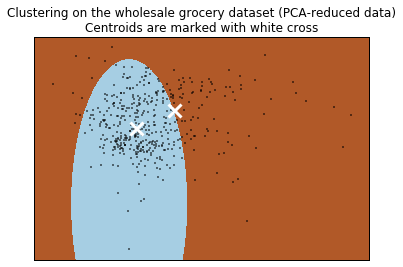

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)
[[ 13444.65629117  -8806.92990638]
 [ 13446.72529064  -8805.18845828]]


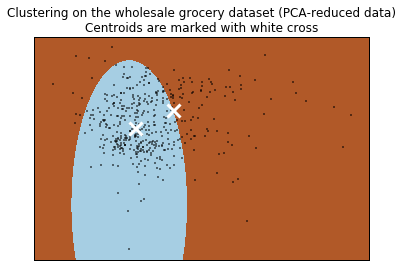

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)
[[ 13444.6591951   -8806.91510978]
 [ 13446.75167695  -8805.18922977]]


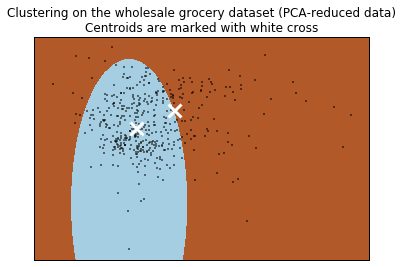

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)
[[ 13444.6591951   -8806.91510978]
 [ 13446.75167695  -8805.18922977]]


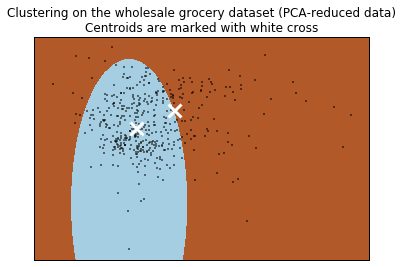

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)
[[ 13444.6591951   -8806.91510978]
 [ 13446.75167695  -8805.18922977]]


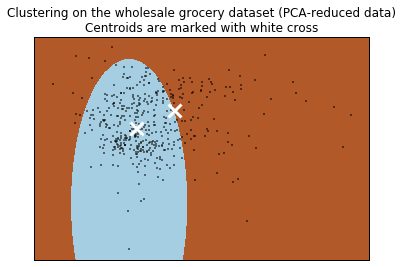

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)
[[ 13444.65629117  -8806.92990638]
 [ 13446.72529064  -8805.18845828]]


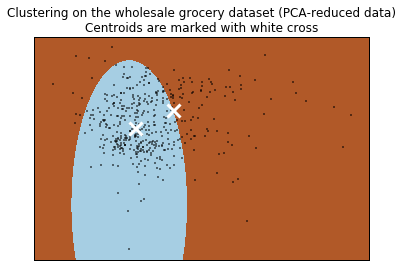

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)
[[ 13446.75167695  -8805.18922977]
 [ 13444.6591951   -8806.91510978]]


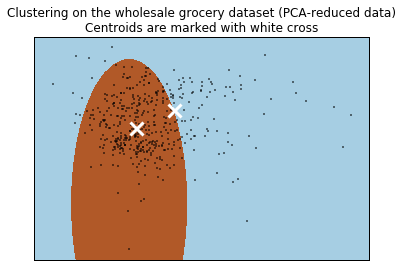

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)
[[ 13446.75167695  -8805.18922977]
 [ 13444.6591951   -8806.91510978]]


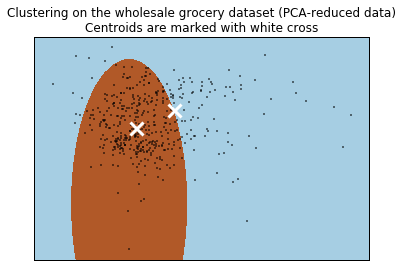

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)
[[ 13446.75167695  -8805.18922977]
 [ 13444.6591951   -8806.91510978]]


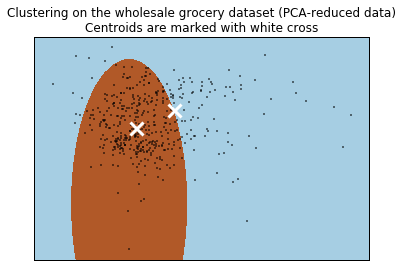

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)
[[ 13444.65945797  -8806.9119063 ]
 [ 13446.75651552  -8805.19081708]]


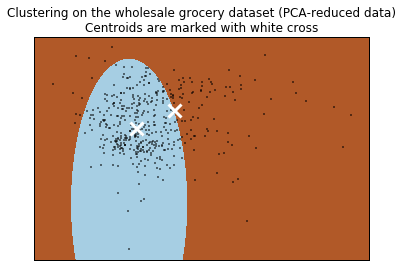

Benchmark: 0.3795643 seconds


In [262]:
benchmark(GMM(n_components=2),'means_')

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)
[[ 13445.9224838   -8803.67098358]
 [ 13445.00494534  -8808.227584  ]]


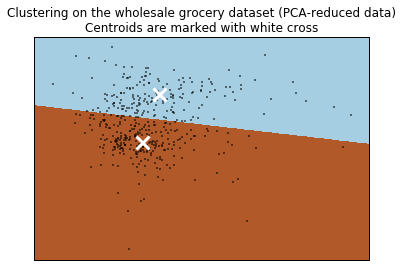

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)
[[ 13445.9224838   -8803.67098358]
 [ 13445.00494534  -8808.227584  ]]


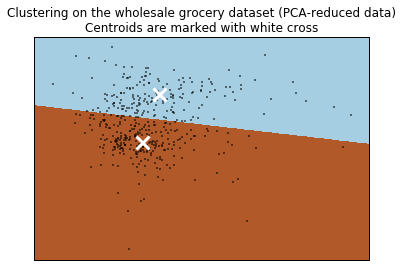

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)
[[ 13445.00494534  -8808.227584  ]
 [ 13445.9224838   -8803.67098358]]


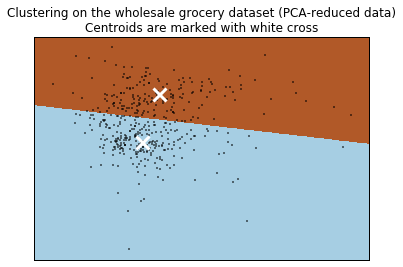

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)
[[ 13445.86150274  -8803.74708857]
 [ 13445.02625821  -8808.29727773]]


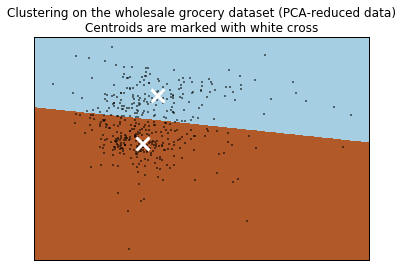

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)
[[ 13445.86150274  -8803.74708857]
 [ 13445.02625821  -8808.29727773]]


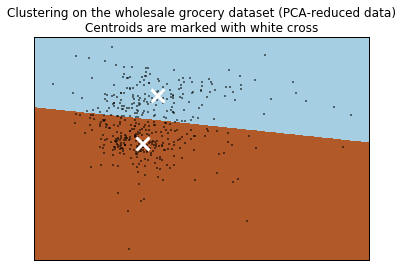

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)
[[ 13445.9224838   -8803.67098358]
 [ 13445.00494534  -8808.227584  ]]


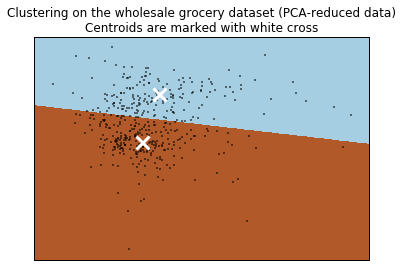

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)
[[ 13445.02625821  -8808.29727773]
 [ 13445.86150274  -8803.74708857]]


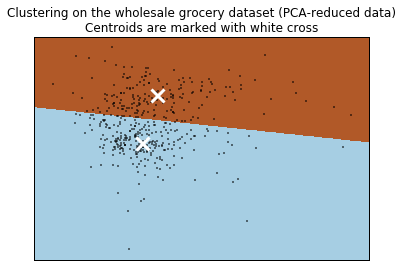

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)
[[ 13445.9224838   -8803.67098358]
 [ 13445.00494534  -8808.227584  ]]


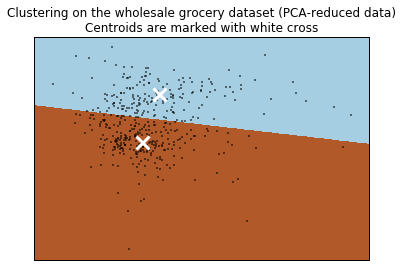

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)
[[ 13445.9224838   -8803.67098358]
 [ 13445.00494534  -8808.227584  ]]


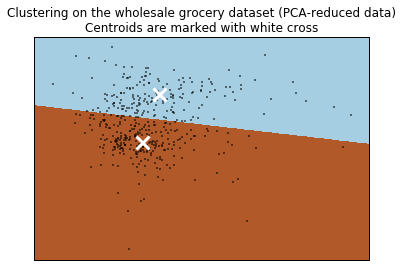

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)
[[ 13445.9224838   -8803.67098358]
 [ 13445.00494534  -8808.227584  ]]


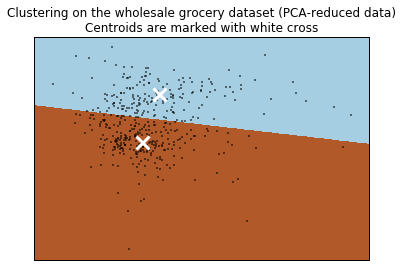

Benchmark: 0.2471809 seconds


In [263]:
benchmark(KMeans(n_clusters=2), 'cluster_centers_')

## Compare clusters

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)
[[ 13446.72529064  -8805.18845828]
 [ 13444.65629117  -8806.92990638]]


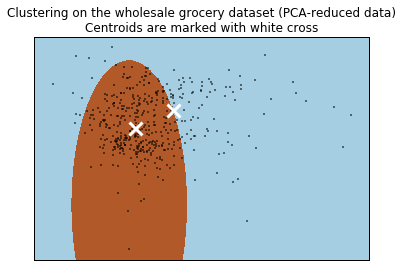

In [264]:
cluster_and_plot(GMM(n_components=2),'means_')

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)
[[ 13445.02625821  -8808.29727773]
 [ 13445.86150274  -8803.74708857]]


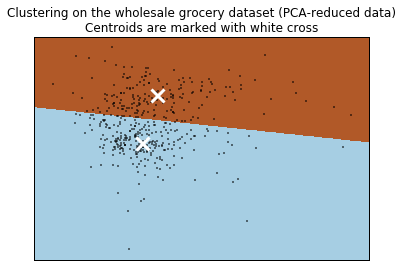

In [265]:
cluster_and_plot(KMeans(n_clusters=2), 'cluster_centers_')

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=3, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)
[[ 13445.10491028  -8804.37781239]
 [ 13444.69465379  -8808.16171999]
 [ 13447.96738673  -8806.78423261]]


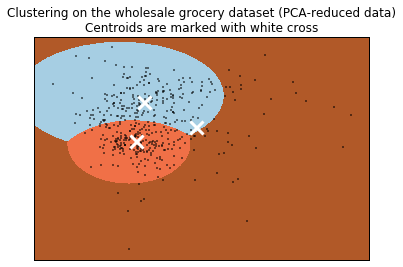

In [266]:
cluster_and_plot(GMM(n_components=3),'means_')

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)
[[ 13444.38353051  -8804.17064585]
 [ 13445.04258211  -8808.59176938]
 [ 13449.2778563   -8804.248122  ]]


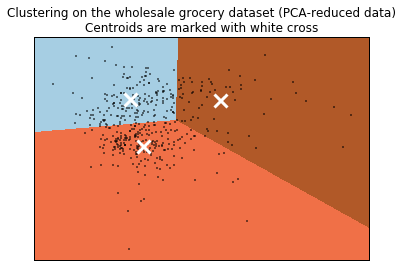

In [267]:
cluster_and_plot(KMeans(n_clusters=3), 'cluster_centers_')

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=4, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001)
[[ 13444.60523226  -8808.05662473]
 [ 13448.53953108  -8803.97763875]
 [ 13444.86057328  -8804.20623005]
 [ 13446.39183398  -8807.92985704]]


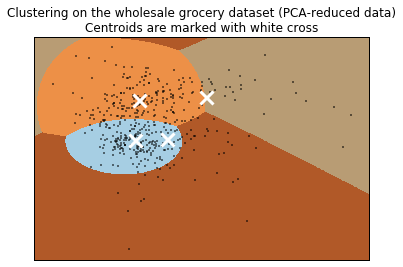

In [268]:
cluster_and_plot(GMM(n_components=4),'means_')

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)
[[ 13444.93150385  -8803.50342376]
 [ 13445.89955575  -8809.44329778]
 [ 13443.98256578  -8807.1733984 ]
 [ 13449.76684314  -8804.42195852]]


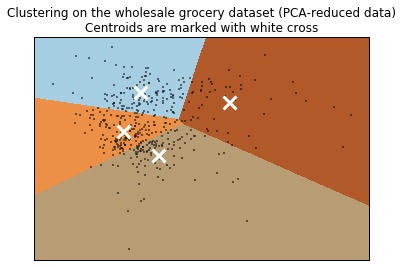

In [269]:
cluster_and_plot(KMeans(n_clusters=4), 'cluster_centers_')

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: 

Central objects in each cluster represent the centroids. In terms of customers, since they are "smack dab in the middle" of each cluster, they seem to represent the "average" customer in that grouping.

###Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: 

I felt that the best techniques to use were to log-transform the data, and then use PCA to summarize the data into two principal components that roughly correspond with "fresh" and "grocery" products respectively. The log transformation was helpful because it helped normalize the data, especially considering that there was huge variation in the annual spending of customers on "fresh" and "grocery" products. After doing PCA, using Gaussian Mixture Models with 2 or 3 components made sense. With 2 GMM components, I could quickly see that one component captures some sort of "oval" clump, while the other captures everything that's not in the oval clump. Perhaps, these 2 clusters correspond to "big" and "small" businesses.  With 3 GMM components, the rough oval shape became divided into two smaller ovals, while the 3rd component captured everything outside the two ovals. 

In the 3-component clusters using GMM, we can identify 3 groups: one of customers that order lots of fresh products, another of customers that order lots of fresh products AND grocery items, and lastly, one of customers that don't belong in those two groups. My hypothesis is that unhappy customers probably belong to the cluster of customers that predominantly order only fresh products. Since the delivery schedule has changed from morning to evening, and now that it's in bulk, those customers are probably most affected. The products in the "fresh" category are probably not as "fresh" as they used to be. Assuming that they have regular hours of operation (i.e. they have more hours open during the day than during night), this means that the fresh products get stored at night, and probably have to wait till the next day to get bought.  Also, "bulk" deliveries probably means we are not delivering to them as frequently. This further supports the idea that the "fresh" products are likely to become more stale because of the new changes.  I would test this idea out, again, by figuring out how concentrated or spread out the unhappy customers are in the clusters.

**9)** How would you use that technique to help the company design new experiments?

Answer: 

Now that we have some clusters, and given the information that some companies have complaints about the new change, I would try to project the customers that we know have issues with the new change onto the first two principal components as we've done above, and then figure out which cluster they belong. An interesting experiment would be to figure out if these unhappy customers are overwhelmingly concentrated in one cluster.  For example, in the case of three GMM clusters, a null hypothesis could be that customers who have problems should be evenly distributed throughout the three clusters. Once we have gathered enough complaints, we could map each of those customers onto the new projection and test our hypothesis. If we can safely reject the null hypothesis (i.e. unhappy customers overwhelmingly are concentrated in one cluster), we could then reach out to the other customers who belong to that cluster, pay more attention to their needs and maybe give them special offers so that they keep doing business with us (such as restoring the daily morning deliveries).

**10)** How would you use that data to help you predict future customer needs?

Answer: 

After the A/B test, if we got to the point of successfully identifying the cluster that most of the unhappy customers belong to, it's probably likely for those people in that cluster to prefer the old method of delivery. We predict that those customers in that cluster probably like more frequent, morning deliveries. In other words, we could assign them labels based on which cluster they belong to. After that, we could treat this as a supervised learning problem.